<a href="https://colab.research.google.com/github/demolakstate/bumble_bees_detection/blob/main/Siamese_Neural_Network_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import random
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from keras.datasets import mnist
#from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import random
import os
import cv2
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array

In [4]:
from tensorflow.keras import layers

In [5]:
from os import path, listdir

In [6]:
import tensorflow as tf


In [7]:
#batch_size = 2608
img_height = 256
img_width = 256

batch_size = 32

In [8]:
dir = "/content/drive/MyDrive/BeeMachine/dataset_2/training2"

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3260 files belonging to 2 classes.
Using 2608 files for training.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Bombus_affinis', 'Bombus_auricomus']


In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


## Visualize the data ##

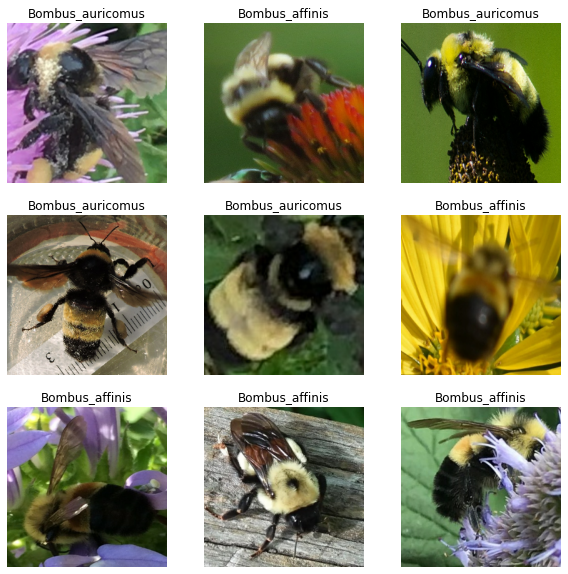

In [12]:
import matplotlib.pyplot

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
def create_pairs(X,Y, num_classes):
    pairs, labels = [], []
    # index of images in X and Y for each class
    class_idx = [np.where(Y==i)[0] for i in range(num_classes)]
    # The minimum number of images across all classes
    min_images = min(len(class_idx[i]) for i in range(num_classes)) - 1
  
    for c in range(num_classes):
        for n in range(min_images):
            # create positive pair
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[c][n+1]]
            pairs.append((img1, img2))
            labels.append(1.0)
      
            # create negative pair
            neg_list = list(range(num_classes))
            neg_list.remove(c)
            # select a random class from the negative list. 
            # this class will be used to form the negative pair
            neg_c = random.sample(neg_list,1)[0]
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[neg_c][n]]
            pairs.append((img1,img2))
            labels.append(0.0)

    return np.array(pairs), np.array(labels)

In [14]:
pairs_train, labels_train = create_pairs(image_batch, labels_batch, 2)

In [15]:
pairs_train[2,0]
labels_train[0]

1.0

###Let us see the image pairs ###

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


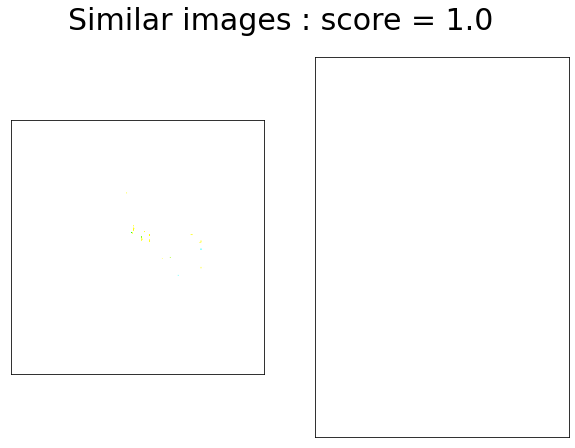

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
ax1.imshow(pairs_train[0, 0], cmap='gray')
ax1.imshow(pairs_train[0, 1], cmap='gray')

for ax in [ax1, ax2]:
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])
  
fig.suptitle(f"Similar images : score = {labels_train[0]}", size=30)
#plt.tight_layout()
plt.show()

In [17]:
def euclidean_distance(vectors):
    vector1, vector2 = vectors
    sum_square = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def contrastive_loss(Y_true, D):
    margin = 1
    return K.mean(Y_true*K.square(D)+(1 - Y_true)*K.maximum((margin-D),0))

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [18]:
def create_shared_network(input_shape):
    model = Sequential(name='Shared_Conv_Network')
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', 
                     input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=128, activation='sigmoid'))
    return model

In [19]:
num_classes = 2

In [20]:
def create_shared_network_2(input_shape):
  model = Sequential([
                      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                      layers.Conv2D(16, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(),
                      layers.Conv2D(32, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(),
                      layers.Conv2D(64, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(),
                      layers.Flatten(),
                      layers.Dense(128, activation='relu'),
                      layers.Dense(num_classes, activation='sigmoid')

  ])

  return model

In [21]:
'''
Main code for training a Siamese neural network for face recognition
'''
# import utils
import numpy as np
from keras.layers import Input, Lambda
from keras.models import Model

# Import Training and Testing Data
X_train = image_batch
Y_train = labels_batch
num_classes = len(np.unique(Y_train))
print(f'num_classes: {num_classes}')

# Create Siamese Neural Network
input_shape = X_train.shape[1:]
shared_network = create_shared_network_2(input_shape)
input_top = Input(shape=input_shape)
input_bottom = Input(shape=input_shape)
output_top = shared_network(input_top)
output_bottom = shared_network(input_bottom)
distance = Lambda(euclidean_distance, output_shape=(1,))([output_top, output_bottom])
model = Model(inputs=[input_top, input_bottom], outputs=distance)

# Train the model
training_pairs, training_labels = create_pairs(X_train, Y_train, 
                                num_classes=num_classes)
model.compile(loss=contrastive_loss, optimizer='adam',
              metrics=[accuracy])



num_classes: 2


In [22]:
model.fit([training_pairs[:, 0], training_pairs[:, 1]], training_labels,
          batch_size=64,
          epochs=20)

Epoch 1/20
1/1 [==============================] - 15s 15s/step - loss: 0.4896 - accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 83ms/step - loss: 0.3772 - accuracy: 0.5167
Epoch 3/20
1/1 [==============================] - 0s 74ms/step - loss: 0.4345 - accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 72ms/step - loss: 0.4002 - accuracy: 0.5500
Epoch 5/20
1/1 [==============================] - 0s 81ms/step - loss: 0.2889 - accuracy: 0.6333
Epoch 6/20
1/1 [==============================] - 0s 77ms/step - loss: 0.2743 - accuracy: 0.7167
Epoch 7/20
1/1 [==============================] - 0s 74ms/step - loss: 0.2261 - accuracy: 0.8167
Epoch 8/20
1/1 [==============================] - 0s 72ms/step - loss: 0.2125 - accuracy: 0.7667
Epoch 9/20
1/1 [==============================] - 0s 71ms/step - loss: 0.1965 - accuracy: 0.8000
Epoch 10/20
1/1 [==============================] - 0s 71ms/step - loss: 0.1620 - accuracy: 0.8000
Epoch 11/20
1/1 [============

In [23]:

# Save the model
model.save('siamese_nn.h5')